In [1]:
!pip install vaderSentiment
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from textblob import Word
from textblob import TextBlob
from pathlib import Path
from google.colab import files
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
#read in file
file_path = '/content/drive/MyDrive/proj4-repo/data/cleaned_data/cleaned_training_tweets.csv'

df = pd.read_csv(file_path)

df.head()

,target,cleaned_text
0,0,upset update facebook texting might cry result...
1,0,dived many time managed save rest go bound
2,0,whole body feel itchy like fire
3,0,behaving see
4,0,whole crew


## grab top 100 rows

In [40]:
df['cleaned_text'] = df['cleaned_text'].astype(str)

In [41]:
df = df['cleaned_text'].head(50000).tolist()


In [42]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [17]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

OSError: Can't load tokenizer for 'cardiffnlp/twitter-roberta-base-sentiment'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'cardiffnlp/twitter-roberta-base-sentiment' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.

In [43]:
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]


In [44]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
#create an empty list
sentiment_labels = []
sentiment_scores = []
for text in df:
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    #Grab rankings
    ranking = np.argsort(scores)
    #ranking = ranking[::-1]
    l = labels[ranking[-1]]
    s = scores[ranking[-1]]
    sentiment_labels.append(l)
    sentiment_scores.append(s)


In [45]:
bert_df_50000 = pd.DataFrame({'cleaned_text':df, 'sentiment_scores':sentiment_scores, 'sentiment_labels':sentiment_labels})

In [46]:
bert_df_50000.head()

,cleaned_text,sentiment_scores,sentiment_labels
0,upset update facebook texting might cry result...,0.799102,negative
1,dived many time managed save rest go bound,0.714438,neutral
2,whole body feel itchy like fire,0.569125,negative
3,behaving see,0.753781,neutral
4,whole crew,0.727418,neutral


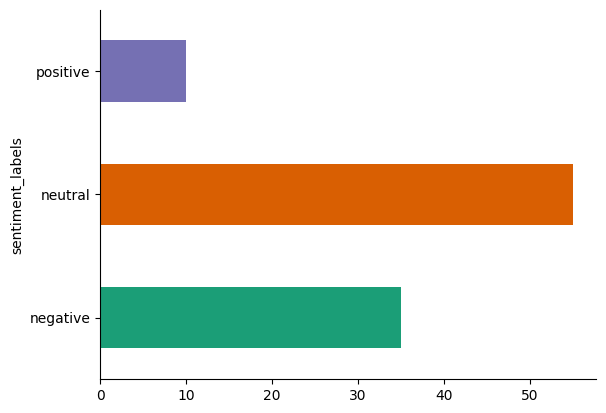

In [47]:
# @title sentiment_labels

from matplotlib import pyplot as plt
import seaborn as sns
bert_df.groupby('sentiment_labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

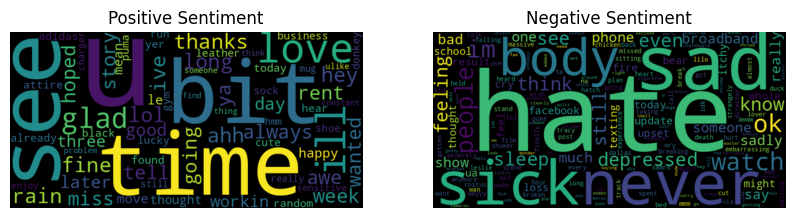

In [48]:
# @title Word Cloud by Sentiment

import matplotlib.pyplot as plt
from wordcloud import WordCloud
positive_words = ' '.join(bert_df[bert_df['sentiment_labels'] == 'positive']['cleaned_text'].tolist())
negative_words = ' '.join(bert_df[bert_df['sentiment_labels'] == 'negative']['cleaned_text'].tolist())
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=400).generate(positive_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment')
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400).generate(negative_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
_ = plt.title('Negative Sentiment')

In [49]:
bert_df_50000.to_csv('bert_sentiment_analysis_50000.csv', index=False)
